In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from config import PATH_LOG

CWD = Path.cwd()

In [2]:
experiment = 'farmsall_vit16_23-08-28T10:03:10'
model_name = 'vit16'
task_name = 'farmsall'   # 선택 - PoC:'cifar10', Farmsall:'farmsall'
log_version = 16    # None: next avaiable version
log_path = PATH_LOG / task_name / f'version_{log_version}'

## OOD Detector Evaluation Results

In [3]:
eval_results = [
    log_path / experiment / f'evaluation_ood_models_farmsall_{model_name}.csv'
]

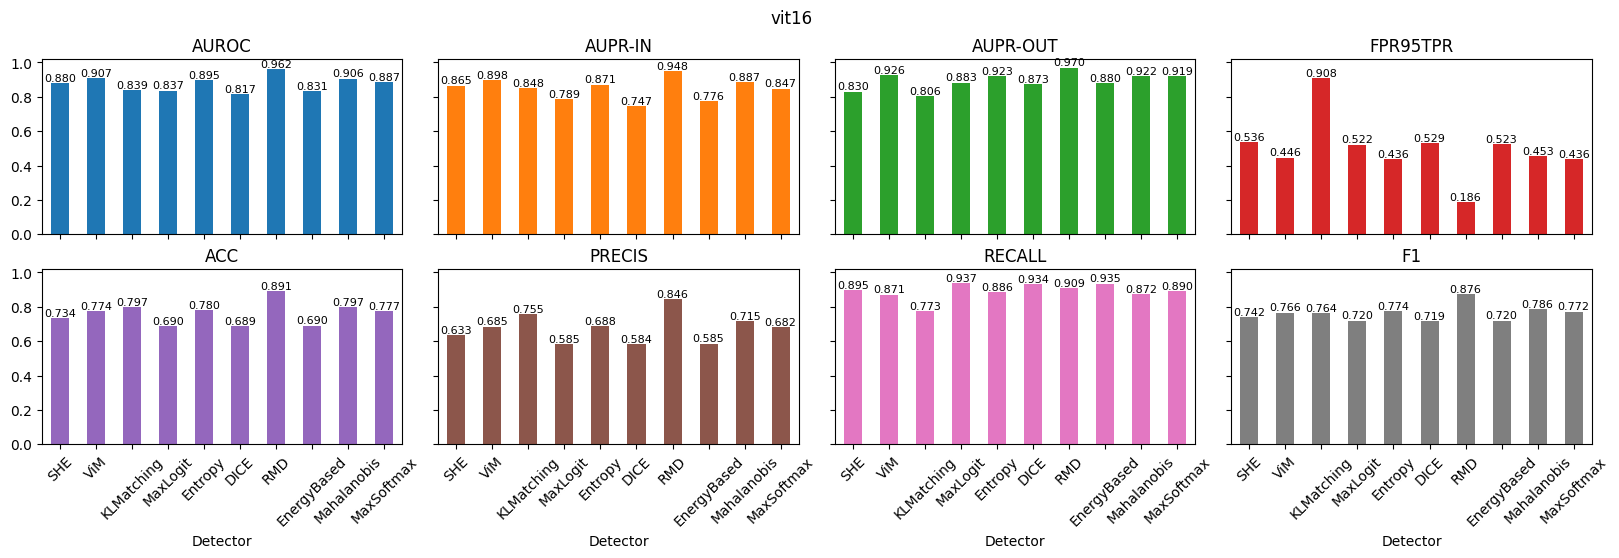

In [4]:
from utils.plots import plot_bar

dfs = pd.DataFrame()
for file in eval_results:
    df = pd.read_csv(file)
    dfs = pd.concat([dfs, df])

dfs_eval = dfs.loc[:, 'Detector': 'F1']
num_plot = dfs.shape[0] - 1
ncols = 2
nrows = int(num_plot/ncols)

for model in dfs.Model.unique():
    df2 = dfs_eval.loc[dfs.Model == model, :].drop('Model', axis=1)
    plot_bar(df2, col_x='Detector', layout=(ncols, nrows), title=model, x_rot=45, figsize=(20,5), sharey=True,
             bar_attr={'fontsize': 8, 'fmt': '%.3f'})
    plt.subplots_adjust(wspace=0.1)  # Adjust the spacing between subplots

## Performance Analysis - Validation Set

In [5]:
import json
from torchmetrics import functional as F
from utils.metric import show_confusion_matrix

PATH_RESULT = log_path / experiment
with (PATH_RESULT / 'evaluation_confusion_matrices.json').open() as fp:
    confusion_matrices = json.load(fp)

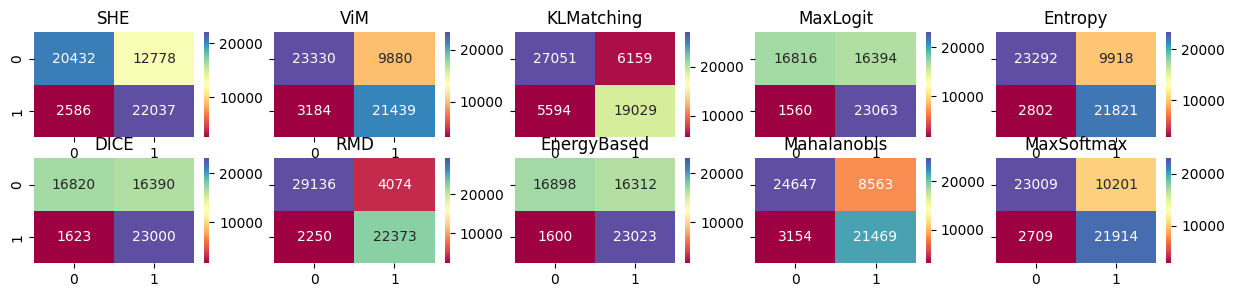

In [6]:
from matplotlib.axes import Axes

detectors = confusion_matrices.keys()
num_plot = len(confusion_matrices)
ncols = 2
nrows = int(num_plot/ncols)
fig, axes = plt.subplots(2, nrows, figsize=(nrows*3,3), sharey=True)
if isinstance(axes, Axes):
    axes = [axes]
else:
    axes = axes.flatten()
for ax, detector in zip(axes, detectors):
    cm = confusion_matrices[detector]
    show_confusion_matrix(cm, ax=ax, title=detector)

## Performance Test -  Test Sets

In [7]:
from trainers import ClassificationTask
from models import get_model
from data.common import get_default_transforms
from data.clf_loaders import get_dataset_info

device = 'cuda'
num_workers = 3

ckpt_file = log_path / 'checkpoints' / 'epoch=39-step=204360.ckpt'
dsinfo = get_dataset_info(task_name=task_name)
num_classes = dsinfo['num_classes']

model_instance = get_model(model_name, num_classes=num_classes)
task = ClassificationTask.load_from_checkpoint(ckpt_file,
                                        model=model_instance
                                        # 추가 parameter들이 들어갈 수 있음
                                        )
model = task.model  # the loaded model

input_params = model.input_params
size = input_params['size']
crop_size = input_params['crop_size']
mean = input_params['mean']
std = input_params['std']
transform = get_default_transforms(mean=mean, std=std, crop_size=crop_size, size=size)

Global seed set to 42
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/kpark/venv/farms/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [8]:
from collections import Counter
import numpy as np
import torch
from models.ood import load_detector, set_device


# Ensemble Model
detectors_to_use = ['RMD', 'Entropy', 'KLMatching']
detectors = [load_detector(log_path / experiment / f'ood_detector_{task_name}_{model_name}_{detector_name}.pkl')
                for detector_name in detectors_to_use]
detectors = [set_device(detector, device) for detector in detectors]


def predict_batch(detectors:list, batch:list, device:str='cpu') -> np.array:
    preds = []
    with torch.no_grad():
        for detector in detectors:
            scores = detector(batch.to(device))
            preds.append((scores.sigmoid() > detector.threshold).tolist())

    if len(detectors) > 1:  # ensemble
        en_pred = np.array(preds)
        # Voting
        preds = np.apply_along_axis(lambda lt: Counter(lt).most_common(1)[0][0], 0, en_pred).tolist()
    else:
        preds = list(np.concatenate(preds))
        
    return preds

### In-set Accuracy 테스트

In [9]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from utils.dataset import make_subset
from data.dataset import CropDisease
from config import PATH_DATA_FARMSALL

subset = False  # False 또는 ratio


inset = CropDisease(PATH_DATA_FARMSALL, kind='valid', transform=transform['valid'])
set_name = inset.__class__.__name__
if subset:
    inset = make_subset(inset, int(len(inset) * subset))
loader_in = DataLoader(inset, batch_size=32,
                            num_workers=num_workers,
                            pin_memory=True)

accs_single, accs_ensemble = {}, {}

preds_single, preds_ensemble = [], []
for batch_x, batch_y in tqdm(loader_in, f'Loading the DataLoader - {set_name}'):
    preds_single.extend(predict_batch(detectors[0:1], batch_x, device=device))
    preds_ensemble.extend(predict_batch(detectors, batch_x, device=device))

assert len(preds_single) == len(preds_ensemble)
preds_single = [not elem for elem in preds_single]
preds_ensemble = [not elem for elem in preds_ensemble]
accs_single[set_name] = (sum(preds_single) / len(preds_single))
accs_ensemble[set_name] = (sum(preds_ensemble) / len(preds_ensemble))
accs_single, accs_ensemble

Loading the DataLoader - CropDisease: 100%|██████████| 1038/1038 [25:02<00:00,  1.45s/it]


({'CropDisease': 0.8773562180066246}, {'CropDisease': 0.8075278530563084})

### OOD-set Accuracy 테스트

In [10]:
from torchvision.datasets import CIFAR10
from pytorch_ood.dataset.img import (
    LSUNCrop,
    LSUNResize,
    Textures,
    TinyImageNetCrop,
    TinyImageNetResize,
)
from data.dataset import Tomato104
from data.dataset import CucumberDisease, KoreanMelonDisease
from data.dataset import LettuceDisease, PapperDisease
from data.dataset import SquashDisease, WaterMelonDisease
from data.dataset import ZucchiniDisease, Zucchini2Disease
from config import PATH_DATA, PATH_DATA_FARMSALL_OOD


ood_sets = [
            CIFAR10(PATH_DATA, train=False, transform=transform['valid'], download=False),
            Textures(PATH_DATA, transform=transform['valid'], download=False),
            CucumberDisease(PATH_DATA_FARMSALL_OOD, kind=None, transform=transform['valid']),
            KoreanMelonDisease(PATH_DATA_FARMSALL_OOD, kind=None, transform=transform['valid']),
            LettuceDisease(PATH_DATA_FARMSALL_OOD, kind=None, transform=transform['valid']),
            PapperDisease(PATH_DATA_FARMSALL_OOD, kind=None, transform=transform['valid']),
            SquashDisease(PATH_DATA_FARMSALL_OOD, kind=None, transform=transform['valid']),
            WaterMelonDisease(PATH_DATA_FARMSALL_OOD, kind=None, transform=transform['valid']),
            ZucchiniDisease(PATH_DATA_FARMSALL_OOD, kind=None, transform=transform['valid']),
            Zucchini2Disease(PATH_DATA_FARMSALL_OOD, kind=None, transform=transform['valid']),
            ]

for ood in ood_sets:
    set_name = ood.__class__.__name__
    if subset:
        ood = make_subset(ood, int(len(ood) * subset))
    loader_ood = DataLoader(ood, batch_size=32,
                            num_workers=num_workers,
                            pin_memory=True)
    
    preds_single, preds_ensemble = [], []
    for batch_x, batch_y in tqdm(loader_ood, f'Loading the DataLoader - {set_name}'):
        preds_single.extend(predict_batch(detectors[0:1], batch_x, device=device))
        preds_ensemble.extend(predict_batch(detectors, batch_x, device=device))
    accs_single[set_name] = (sum(preds_single) / len(preds_single))
    accs_ensemble[set_name] = (sum(preds_ensemble) / len(preds_ensemble))

Loading the DataLoader - Zucchini2Disease: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


In [11]:
with (PATH_RESULT / 'accuracies_on_sets.json').open('w') as fp:
    json.dump({detectors_to_use[0]: accs_single,
                ','.join(detectors_to_use): accs_ensemble}, fp, indent=4)

<Axes: title={'center': 'RMD, Accuracy - IN/OOD'}, xlabel='dataset'>

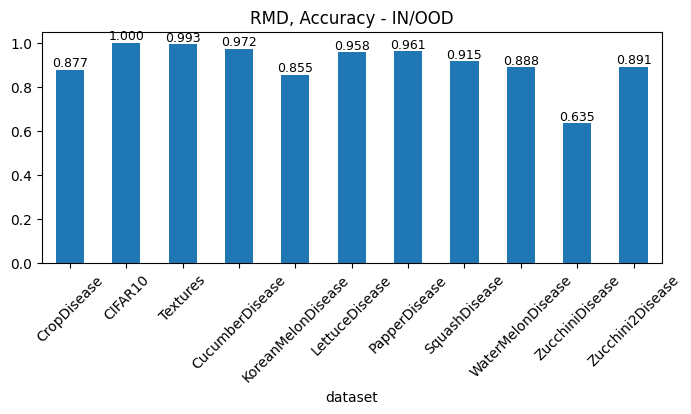

In [12]:
plot_bar(pd.DataFrame({'dataset': accs_single.keys(), 'accuracy': accs_single.values()}),
        col_x='dataset', title=f'{detectors_to_use[0]}, Accuracy - IN/OOD', x_rot=45,
        figsize=(8,3), bar_attr={'fontsize':9, 'fmt': '%.3f'})

<Axes: title={'center': 'Ensemble, Accuracy - IN/OOD'}, xlabel='dataset'>

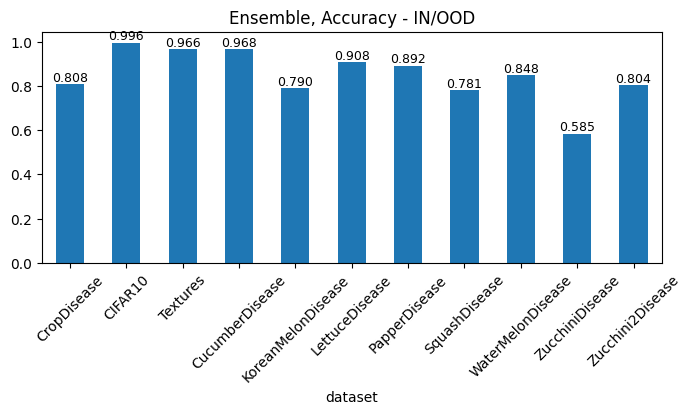

In [13]:
plot_bar(pd.DataFrame({'dataset': accs_ensemble.keys(), 'accuracy': accs_ensemble.values()}),
        col_x='dataset', title=f'Ensemble, Accuracy - IN/OOD', x_rot=45,
        figsize=(8,3), bar_attr={'fontsize':9, 'fmt': '%.3f'})